# Training a model to recognize sentiment in text

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import io
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
training_size = 20000

In [4]:
with open("sarcasm.json", "r") as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item["headline"])
    labels.append(item["is_sarcastic"])

In [5]:
len(sentences)

26709

In [6]:
training_size = 20000

In [7]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [8]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

In [9]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [11]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(24, activation = "relu"),
                             tf.keras.layers.Dense(1, activation = "sigmoid")
])
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
num_epochs = 30
history = model.fit(training_padded,
                    training_labels,
                    epochs = num_epochs,
                    validation_data = (testing_padded, testing_labels),
                    verbose = 2)

Epoch 1/30
625/625 - 2s - loss: 0.0248 - accuracy: 0.9936 - val_loss: 1.0534 - val_accuracy: 0.8135 - 2s/epoch - 3ms/step
Epoch 2/30
625/625 - 2s - loss: 0.0230 - accuracy: 0.9941 - val_loss: 1.1251 - val_accuracy: 0.8138 - 2s/epoch - 3ms/step
Epoch 3/30
625/625 - 2s - loss: 0.0220 - accuracy: 0.9942 - val_loss: 1.1076 - val_accuracy: 0.8101 - 2s/epoch - 3ms/step
Epoch 4/30
625/625 - 2s - loss: 0.0218 - accuracy: 0.9941 - val_loss: 1.1923 - val_accuracy: 0.8114 - 2s/epoch - 3ms/step
Epoch 5/30
625/625 - 2s - loss: 0.0184 - accuracy: 0.9955 - val_loss: 1.1949 - val_accuracy: 0.8111 - 2s/epoch - 3ms/step
Epoch 6/30
625/625 - 2s - loss: 0.0193 - accuracy: 0.9944 - val_loss: 1.2743 - val_accuracy: 0.8092 - 2s/epoch - 3ms/step
Epoch 7/30
625/625 - 2s - loss: 0.0169 - accuracy: 0.9958 - val_loss: 1.2814 - val_accuracy: 0.8092 - 2s/epoch - 3ms/step
Epoch 8/30
625/625 - 2s - loss: 0.0168 - accuracy: 0.9959 - val_loss: 1.2929 - val_accuracy: 0.8070 - 2s/epoch - 3ms/step
Epoch 9/30
625/625 - 2s 

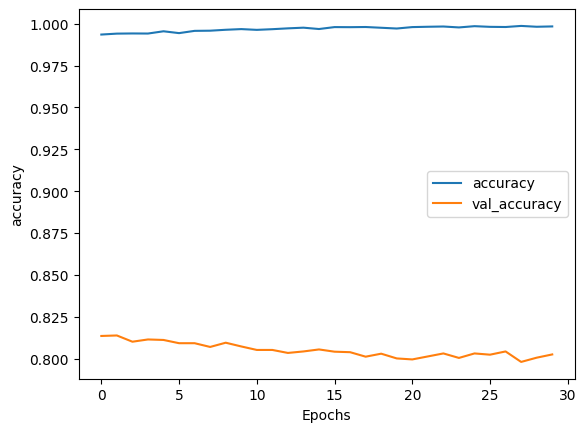

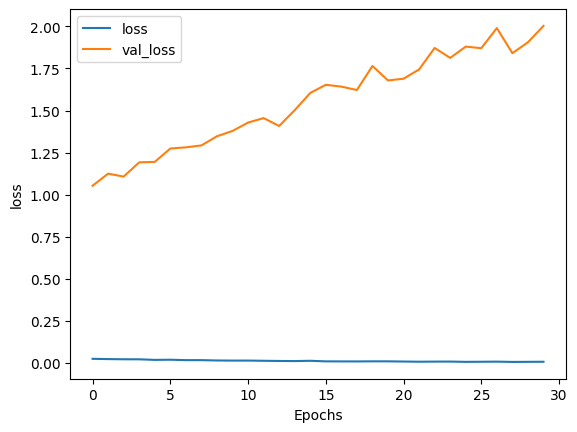

In [15]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history[f"val_{string}"])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, f"val_{string}"])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [16]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [17]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [18]:
out_v = io.open("vecs.tsv", "w", encoding = "utf-8")
out_m = io.open("meta.tsv", "w", encoding = "utf-8")

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write("\t".join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [19]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 96ms/step
[[3.3549100e-01]
 [7.3201737e-13]]
